# Traning for SY 1.9 & 2.0

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## define functions

In [2]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def plotData(data):
        plt.plot(np.linspace(3800,len(data)-1+3800,len(data)), data.tolist(),linewidth=1)
        
def plotFilters(filters):
    filters = filters.flatten()[1:-1].reshape(-1,2)
    for x in filters:
        plt.axvspan(x[0]+3800, x[1]+3800, alpha=0.5, facecolor='grey')
        
def sizeMap(inputSize):
    IN = inputSize
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    return IN, C1, S2, C3, S4


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list
    
    

## AGN Emission Lines (3000 - 8000 A)
https://ned.ipac.caltech.edu/level5/Netzer/Netzer2_1.html

```
CIII λ977
OVI λ1035
Lα
NV λ1240
OI λ1304
CII λ1336
SiIV,OIV] λ1400
NIV] λ1486
CIV λ1549 
HeII λ1640
OIII] λ1663
NIII] λ1750
CIII] λ1909
FeII λ(2200-2800)  
MgII λ2798
[NeV] λ3426
[OII] λ3727
[NeIII] λ3869
HeII λ4686
Hβ λ4861
[OIII] λ4959,5007
FeII λ(4500-5400) 
HeI λ5876
[FeVII] λ6087
[OI] λ6300
[FeX] λ6374
Hα λ6563
[NII] λ6583
[SII] λ6716,6731
CaII λ8498-8662
[SIII] λ9069,9532
```

The emission line spectrum of active galactic nuclei and the unifying scheme
https://link.springer.com/article/10.1007%2Fs001590000006

```
(Broad permmited lines)
HI, HeI λλ5876,6678,7065
He II λ4686
Fe II visible domain

(narrow line)
[Fe VII] λ6087
[Fe X] λ6375
[Fe XI] λ7892
```

add more balmer lines
```
Hγ λ4340
H-δ λ4102
```


FeII Lines, Table I in
https://arxiv.org/pdf/1004.2212.pdf


without FeII:

lines = [3869,4102,4340,4686,4861,4959,5007,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]


with Fe II:

lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]

In [3]:
def _filters(lines, width, Ha_width=280, Hb_width=120, Hg_width=60):
    boundery_00 = np.array([3800,4500])
    boundery_0 = np.array([[line-width/2,line+width/2] for line in lines if line<4338]).flatten()
    boundery_Hg = np.array([4340-Hg_width/2,4340+Hg_width/2]).flatten()
    boundery_1 = np.array([[line-width/2,line+width/2] for line in lines if (line>4342 and line<4860)]).flatten()
    boundery_Hb = np.array([4861-Hb_width/2,4861+Hb_width/2]).flatten()
    boundery_2 = np.array([[line-width/2,line+width/2] for line in lines if (line>4862 and line<6560)]).flatten()
    boundery_Ha = np.array([6563-Ha_width/2,6563+Ha_width/2]).flatten()
    boundery_3 = np.array([[line-width/2,line+width/2] for line in lines if line>6566]).flatten()
    boundery = np.concatenate((boundery_00,boundery_0, boundery_Hg, boundery_1,boundery_Hb,boundery_2,boundery_Ha,boundery_3),axis=0).reshape(-1,2)
    # 1st filter, filter the right boundery, ignore those right right bouderies smaller than the previous one
    index = [1]
    while len(index):
        signs = np.sign(boundery[1:]-boundery[:-1])
        index = np.argwhere(signs==-1)[:,0]+1
        if len(index)>0:
            boundery = np.delete(boundery,index,0)
    #print(boundery)
    # 2nd filter, compare right boundery and next left boundery, if smaller, merge two intervals.
    boundery = boundery.flatten()
    filters = []
    filters.append(boundery[0]) 
    i = 1
    while i< (len(boundery)-1):
        if boundery[i]<boundery[i+1]:
            filters.append(boundery[i])
            i=i+1
        else: 
            i=i+2
    filters.append(boundery[-1])
    return np.array(filters).reshape(-1,2)

def _filterTensor(tensor, lines, width, begin=3800, end=7500):
    filters = _filters(lines, width).flatten()
    filters = np.insert(filters,0,begin)
    filters = np.append(filters,end)
    filters = filters.reshape(-1,2)
    filters = (filters-3800).astype(int)
    if len(tensor.size()) == 1:
        return torch.cat([tensor[f[0]:f[1]] for f in filters],dim=1), filters
    else:
        return torch.cat([tensor[:,f[0]:f[1]] for f in filters],dim=1), filters

## read  data

In [4]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
sy19_feature_train = read_data('type1-pixels-3800-7500-redshifted-normalized-train.csv', delimiter=',')
sy19_feature_test = read_data('type1-pixels-3800-7500-redshifted-normalized-test.csv', delimiter=',')
sy20_feature_1 = read_data('sy20-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_2 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
sy20_feature_3 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.1.csv', delimiter=',')
sy20_feature_4 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.2.csv', delimiter=',')
sy20_feature_5 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.3.csv', delimiter=',')
sy20_feature_6 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.4.csv', delimiter=',')
sy20_feature_7 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.5.csv', delimiter=',')
sy20_feature_8 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.6.csv', delimiter=',')

In [5]:
## read sy19 with noise   
#sy19_noise_feature_train = []
#for file in glob.glob('sy19-pixels*noise*'):
#    print('reading:', file)
#    file_feature = read_data(file, delimiter=',')
#    sy19_noise_feature_train = np.concatenate((sy19_noise_feature_train, file_feature), axis=0)
#
#sy19_noise_feature_test = []
#for file in glob.glob('sy19-test*noise*'):
#    print('reading:', file)
#    file_feature = read_data(file, delimiter=',')
#    sy19_noise_feature_test = np.concatenate((sy19_noise_feature_test, file_feature), axis=0)

In [6]:
##  Small sample pre-traning
#sy19_feature = sy19_feature_1
#sy20_feature = sy20_feature_1

## Full sample
#sy19_feature_train = np.concatenate((sy19_feature_train,  sy19_noise_feature_train), axis=0)
sy20_feature = np.concatenate((sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,\
                               sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8), axis=0)

sy19_feature_train = torch.Tensor(sy19_feature_train).view(-1,7500-3800+1)
sy19_feature_test = torch.Tensor(sy19_feature_test).view(-1,7500-3800+1)
sy20_feature = torch.Tensor(sy20_feature).view(-1,7500-3800+1)

In [7]:
# filter wavelength
lines = [3869,4102,4340,4473,4489,4491,4508,4515,4520,4523,4534,4542,4549,4556,4576,4583,4621,4629,4667,4686,4731,4861,4924,4959,4993,5007,5018,5146,5169,5198,5235,5265,5276,5284,5317,5326,5338,5363,5414,5425,5876,6087,6300,6374,6563,6583,6678,6716,6731,7065]
width = 50

sy19_feature_train_filtered, filters = _filterTensor(sy19_feature_train, lines, width, begin=3800, end=7500)
sy19_feature_test_filtered, filters = _filterTensor(sy19_feature_test, lines, width, begin=3800, end=7500)
sy20_feature_filtered, filters = _filterTensor(sy20_feature, lines, width, begin=3800, end=7500)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'Density')

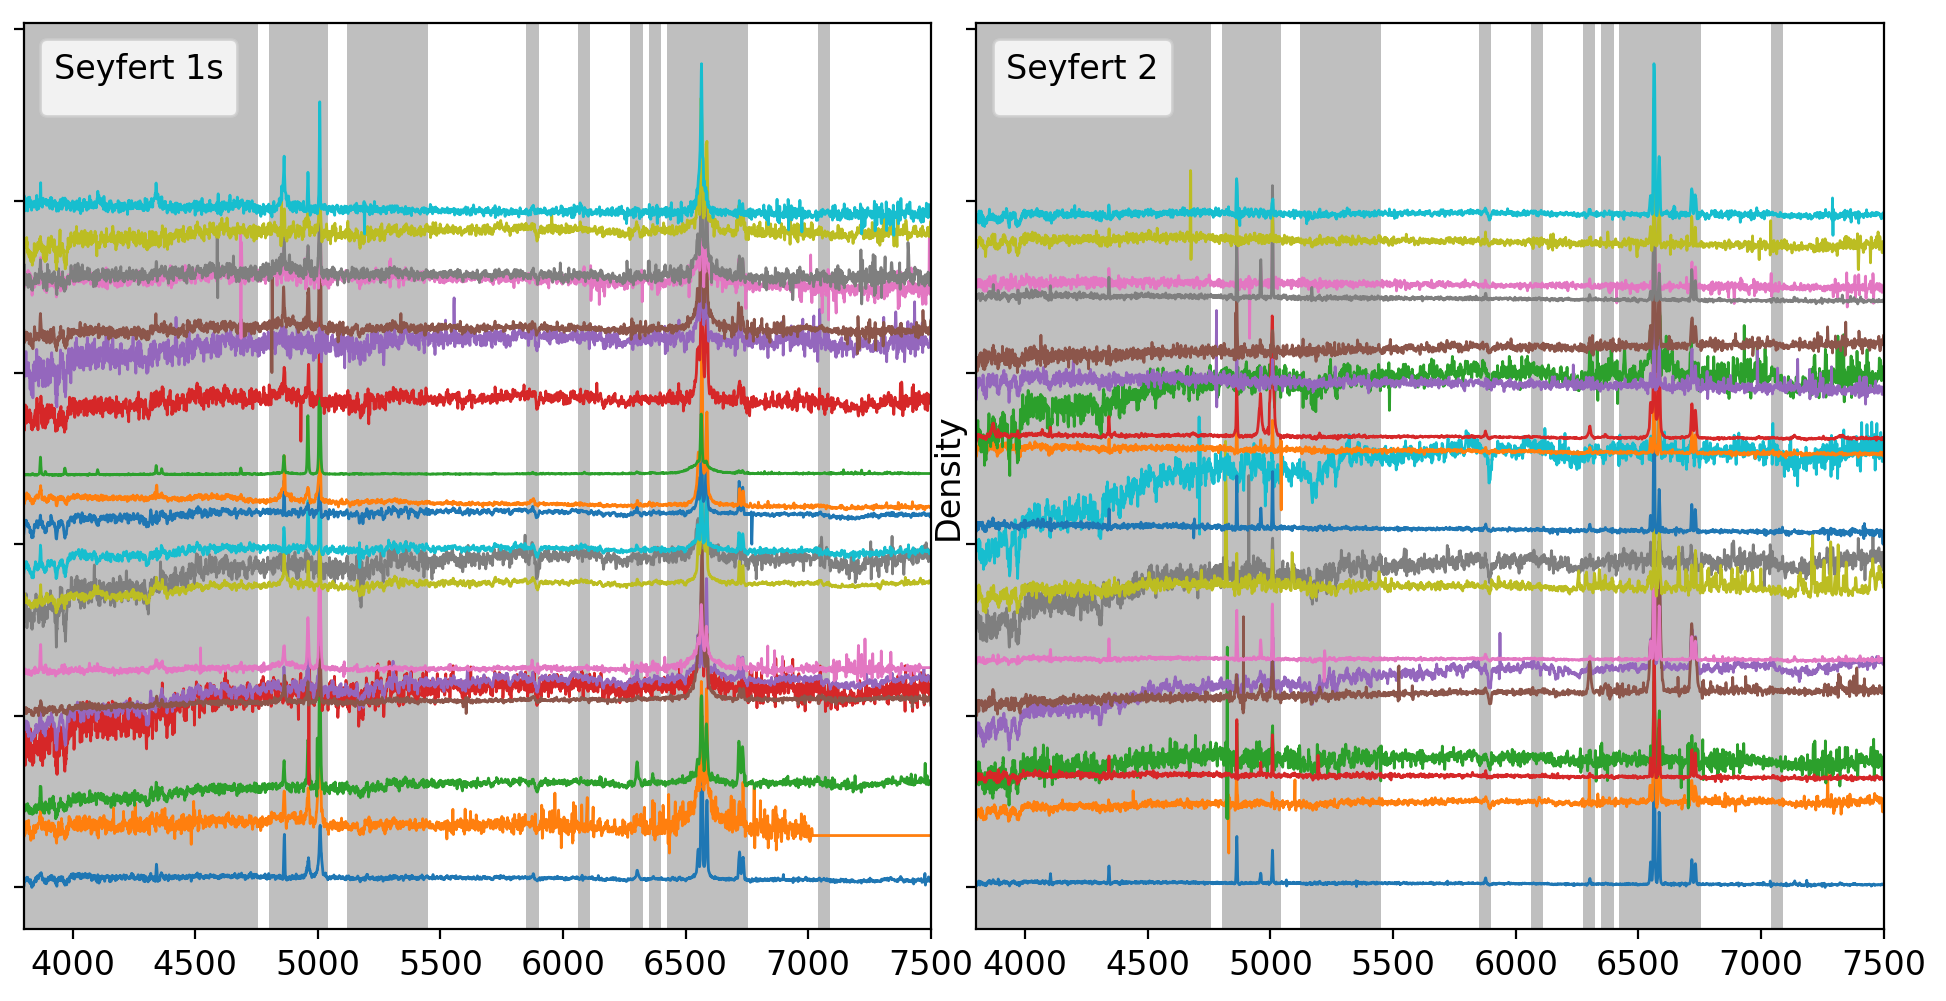

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace = 0.05)
for i in range(20):
    plt.sca(axs[0])
    axs[0].set_yticklabels([])
    plotData(sy19_feature_test[i]+i/5)
plotFilters(filters)
plt.legend(title='Seyfert 1s',loc=2)
for i in range(20):
    plt.sca(axs[1])
    axs[1].set_yticklabels([])
    plotData(sy20_feature[i]+i/5)
plotFilters(filters)
plt.legend(title='Seyfert 2',loc=2)


plt.xlim(3800,7500)

plt.ylabel('Density')

In [9]:
# classify 1.9 as 1, and 2 as 0. 
sy19_label_train = torch.ones(sy19_feature_train.size(0),dtype=torch.long)
sy19_label_test = torch.ones(sy19_feature_test.size(0),dtype=torch.long)
sy20_label = torch.zeros(sy20_feature.size(0),dtype=torch.long)

# create indices
sy19_indice_train = torch.linspace(0,len(sy19_feature_train)-1,len(sy19_feature_train)).int()
sy19_indice_test = torch.linspace(0,len(sy19_feature_test)-1,len(sy19_feature_test)).int()
sy20_indice = torch.linspace(0,len(sy20_feature)-1,len(sy20_feature)).int()

# taking same number of 1.9 and 2.0 seyfert galaxies
sy19_dataset_train = TensorDataset(sy19_indice_train,sy19_feature_train_filtered,sy19_label_train)
sy19_dataset_test = TensorDataset(sy19_indice_test,sy19_feature_test_filtered,sy19_label_test)

sy20_dataset_train = TensorDataset(sy20_indice[:len(sy19_dataset_train)],sy20_feature_filtered[:len(sy19_dataset_train)],sy20_label[:len(sy19_dataset_train)])
sy20_dataset_test = TensorDataset(sy20_indice[len(sy19_dataset_train):],sy20_feature_filtered[len(sy19_dataset_train):],sy20_label[len(sy19_dataset_train):])

# merge the test dataset
dataset = ConcatDataset((sy19_dataset_train,sy20_dataset_train))

## CNN Network - One layer of Full CNN

### computing output size of image


- i = input
- o = output
- p = padding
- k = kernel_size
- s = stride
- d = dilation

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

In your case this gives o = [32 + 2 - 3 - 2*1]/1 +1 = [29] + 1 = 30.
Now, you could set all your parameters and “solve” the equation for p.
You will see, that p=2 will give you an output size of 32.

You could  with some tools like ezyang’s convolution visualizer 308 or calculate it with this formula:
https://ezyang.github.io/convolution-visualizer/index.html



###  Network Map

| Layer | Type | Maps | Kernel_size | Padding | Stride | Image_size | Activation | Comment |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  Out | Linear | - | - | - | - | 2 | - |  |
|  F7 | Linear | - | - | - | - | 100 | ReLU | 1000 -> 100  |
|  D6 | Dropout (0.5) | - | - | - | - | - | - | - |
|  C5 | Convolution | 1000 | 888 | 0 | 1 | 1 | ReLU |  |
|  S4 | Avg Pooling | 128 | 2 | 0 | 2 | 888 | - |  |
|  C3 | Convolution | 128 | 50 | 0 | 1 | 1777 | ReLU |  |
|  S2 | Avg Pooling | 64 | 2 | 0 | 2 | 1826 | - |  |
|  C1 | Convolution | 64 | 50 | 0 | 1 | 3652 | ReLU |  |
| In | Input | 1 | - | - |- | 3701 |- | |

In [10]:
sizes = sizeMap(sy19_feature_test_filtered[1].size(0))

In [11]:
sizes

(1591, 1542, 771, 722, 361)

In [12]:
class simpleCNN(nn.Module):
    
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 128, 50)
        self.S4 = nn.AvgPool1d(2, stride=2)
        self.C5 = nn.Conv1d(128, 1000, sizes[4])
        self.D6 = nn.Dropout(0.5)
        self.F7 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.C1(x),inplace=True)
        x = self.S2(x)
        x = F.relu(self.C3(x),inplace=True)
        x = self.S4(x)
        x = F.relu(self.C5(x),inplace=True)
        x = self.D6(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F7(x),inplace=True)
        x = self.Out(x)
        return x

In [13]:
net = simpleCNN()
print(net)

simpleCNN(
  (C1): Conv1d(1, 64, kernel_size=(50,), stride=(1,))
  (S2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C3): Conv1d(64, 128, kernel_size=(50,), stride=(1,))
  (S4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C5): Conv1d(128, 1000, kernel_size=(361,), stride=(1,))
  (D6): Dropout(p=0.5, inplace=False)
  (F7): Linear(in_features=1000, out_features=100, bias=True)
  (Out): Linear(in_features=100, out_features=2, bias=True)
)


In [14]:
## Test
x = torch.randn(5,1,sizes[0])
net(x)

tensor([[-0.0748,  0.1087],
        [-0.0488,  0.1051],
        [-0.0537,  0.1234],
        [-0.0432,  0.0988],
        [-0.0431,  0.1170]], grad_fn=<AddmmBackward>)

### Check GPU availabel

In [15]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net.cuda(3)
    device = torch.device('cuda:3')
    print ('USE GPU')
else:
    device = torch.device('cpu')
    print ('USE CPU')

USE GPU


### define  accuracy 

In [16]:
def accuracy(y_hat, y):
#    y_hat = torch.sign(y_hat)
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter, net, device):
    acc = torch.tensor([0.0], device=device)
    for (index, img, label) in data_iter:
        img = img.view(-1,1,sizes[0])
        # 如果 device 是 GPU，将数据复制到 GPU 上。
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        acc += accuracy(net(img), label)
    return acc.item() / len(data_iter)

### TRAINING

In [17]:
learning_rate = 0.01

loss = nn.CrossEntropyLoss() # 包含了softmax 和 cross entropy
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-8)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [18]:
num_epochs = 500

batch_size = 64
train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
## laod previous traning results
#
#net.load_state_dict(torch.load('cuda3-GOOD.pt'))
#
#previous = pd.read_csv('./runs/acc-list-cuda3-2019-07-22-15-02-10-826651-GOOD.csv', header=0, comment='#')
#
#loss_list = list(previous['loss'])
#sy19_test_acc_list = list(previous['sy19_test_acc'])
#sy20_test_acc_list = list(previous['sy20_test_acc'])
#train_acc_list = list(previous['train_acc'])

In [ ]:
sy19_test_acc_list = []
sy20_test_acc_list = []
train_acc_list = []
loss_list = []

In [22]:
for epoch in range(num_epochs):
    net.train() 
    start = time.time()
    train_l_sum = 0.
    train_acc_sum = 0.
    for (index, img, label) in train_iter:
        img = img.view(-1,1,sizes[0])
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        optimizer.zero_grad()
        predict = net(img)
        l = loss(predict, label.view(-1))
        l.backward()
        optimizer.step()
        train_l_sum += l.data.item()
        train_acc_sum += accuracy(predict, label.view(-1))
        #print(l)
    
    if ((epoch+1)%1 ==0):
        net.eval() 
        sy19_test_iter = DataLoader(sy19_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        sy19_test_acc = evaluate_accuracy(sy19_test_iter, net, device)
        sy20_test_iter = DataLoader(sy20_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        sy20_test_acc = evaluate_accuracy(sy20_test_iter, net, device)
        
        print('epoch %d, loss %.6f, train acc %.6f, sy19 test acc  %.4f, sy20 test acc  %.4f, '
                'time %.1f sec' % (epoch + 1, train_l_sum / len(train_iter),
                                    train_acc_sum / len(train_iter),
                                    sy19_test_acc, sy20_test_acc, time.time() - start))
        sy19_test_acc_list.append(sy19_test_acc)
        sy20_test_acc_list.append(sy20_test_acc)
        loss_list.append(train_l_sum / len(train_iter))
        train_acc_list.append(train_acc_sum / len(train_iter))
        if (train_l_sum / len(train_iter) < 0.5):
            learning_rate = 0.001
            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        if (train_l_sum / len(train_iter) < 0.005):
            learning_rate = 0.0001
            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)        

epoch 1, loss 0.576757, train acc 0.680613, sy19 test acc  0.8199, sy20 test acc  0.5963, time 33.9 sec
epoch 2, loss 0.564869, train acc 0.695186, sy19 test acc  0.7970, sy20 test acc  0.6526, time 33.3 sec
epoch 3, loss 0.565012, train acc 0.696127, sy19 test acc  0.8737, sy20 test acc  0.4697, time 34.2 sec
epoch 4, loss 0.561350, train acc 0.695629, sy19 test acc  0.6129, sy20 test acc  0.7260, time 33.0 sec
epoch 5, loss 0.565913, train acc 0.687057, sy19 test acc  0.8910, sy20 test acc  0.4363, time 33.9 sec
epoch 6, loss 0.555636, train acc 0.702350, sy19 test acc  0.8468, sy20 test acc  0.6102, time 32.9 sec
epoch 7, loss 0.556895, train acc 0.706043, sy19 test acc  0.8678, sy20 test acc  0.5109, time 33.8 sec
epoch 8, loss 0.555618, train acc 0.704556, sy19 test acc  0.5794, sy20 test acc  0.8078, time 33.1 sec
epoch 9, loss 0.547329, train acc 0.713057, sy19 test acc  0.6820, sy20 test acc  0.7630, time 33.4 sec
epoch 10, loss 0.536144, train acc 0.721628, sy19 test acc  0.87

epoch 80, loss 0.411603, train acc 0.808222, sy19 test acc  0.8094, sy20 test acc  0.6928, time 34.7 sec
epoch 81, loss 0.410922, train acc 0.812832, sy19 test acc  0.7970, sy20 test acc  0.6964, time 33.7 sec
epoch 82, loss 0.408285, train acc 0.812429, sy19 test acc  0.8179, sy20 test acc  0.6707, time 34.2 sec
epoch 83, loss 0.407411, train acc 0.810136, sy19 test acc  0.7883, sy20 test acc  0.6998, time 34.1 sec
epoch 84, loss 0.408175, train acc 0.814240, sy19 test acc  0.8183, sy20 test acc  0.6783, time 34.1 sec
epoch 85, loss 0.409746, train acc 0.804363, sy19 test acc  0.7604, sy20 test acc  0.7373, time 33.9 sec
epoch 86, loss 0.402791, train acc 0.811235, sy19 test acc  0.7979, sy20 test acc  0.6988, time 34.3 sec
epoch 87, loss 0.406152, train acc 0.816533, sy19 test acc  0.7866, sy20 test acc  0.7074, time 33.9 sec
epoch 88, loss 0.398827, train acc 0.814137, sy19 test acc  0.8114, sy20 test acc  0.6843, time 34.3 sec
epoch 89, loss 0.401728, train acc 0.814888, sy19 test 

epoch 158, loss 0.292096, train acc 0.873482, sy19 test acc  0.7901, sy20 test acc  0.6702, time 32.1 sec
epoch 159, loss 0.291820, train acc 0.873482, sy19 test acc  0.7905, sy20 test acc  0.6800, time 32.1 sec
epoch 160, loss 0.285843, train acc 0.879191, sy19 test acc  0.8166, sy20 test acc  0.6527, time 32.0 sec
epoch 161, loss 0.282373, train acc 0.883200, sy19 test acc  0.7738, sy20 test acc  0.7005, time 32.0 sec
epoch 162, loss 0.287873, train acc 0.877388, sy19 test acc  0.7825, sy20 test acc  0.6944, time 32.0 sec
epoch 163, loss 0.282275, train acc 0.879594, sy19 test acc  0.8283, sy20 test acc  0.6388, time 32.1 sec
epoch 164, loss 0.279623, train acc 0.880195, sy19 test acc  0.7549, sy20 test acc  0.7093, time 32.1 sec
epoch 165, loss 0.277688, train acc 0.886505, sy19 test acc  0.7883, sy20 test acc  0.6724, time 32.0 sec
epoch 166, loss 0.276893, train acc 0.882907, sy19 test acc  0.8075, sy20 test acc  0.6644, time 32.0 sec
epoch 167, loss 0.270435, train acc 0.887312, 

epoch 236, loss 0.149406, train acc 0.941999, sy19 test acc  0.8175, sy20 test acc  0.6232, time 32.0 sec
epoch 237, loss 0.144539, train acc 0.947614, sy19 test acc  0.8259, sy20 test acc  0.6249, time 32.0 sec
epoch 238, loss 0.147290, train acc 0.946111, sy19 test acc  0.8077, sy20 test acc  0.6515, time 32.0 sec
epoch 239, loss 0.139854, train acc 0.946514, sy19 test acc  0.8105, sy20 test acc  0.6471, time 32.0 sec
epoch 240, loss 0.156077, train acc 0.940299, sy19 test acc  0.8622, sy20 test acc  0.5721, time 32.0 sec
epoch 241, loss 0.152871, train acc 0.941153, sy19 test acc  0.7927, sy20 test acc  0.6698, time 32.0 sec
epoch 242, loss 0.139830, train acc 0.947052, sy19 test acc  0.8148, sy20 test acc  0.6311, time 32.0 sec
epoch 243, loss 0.142441, train acc 0.947013, sy19 test acc  0.8320, sy20 test acc  0.6146, time 32.0 sec
epoch 244, loss 0.134071, train acc 0.949614, sy19 test acc  0.8042, sy20 test acc  0.6462, time 32.0 sec
epoch 245, loss 0.137609, train acc 0.948017, 

epoch 314, loss 0.072269, train acc 0.974206, sy19 test acc  0.8320, sy20 test acc  0.6067, time 32.1 sec
epoch 315, loss 0.077995, train acc 0.973004, sy19 test acc  0.8422, sy20 test acc  0.6054, time 32.3 sec
epoch 316, loss 0.074488, train acc 0.971905, sy19 test acc  0.7862, sy20 test acc  0.6511, time 32.2 sec
epoch 317, loss 0.078647, train acc 0.971344, sy19 test acc  0.8320, sy20 test acc  0.6136, time 32.0 sec
epoch 318, loss 0.075582, train acc 0.973597, sy19 test acc  0.8348, sy20 test acc  0.6069, time 32.0 sec
epoch 319, loss 0.068031, train acc 0.977962, sy19 test acc  0.8530, sy20 test acc  0.5829, time 32.1 sec
epoch 320, loss 0.076597, train acc 0.974957, sy19 test acc  0.8442, sy20 test acc  0.5932, time 32.0 sec
epoch 321, loss 0.075604, train acc 0.974206, sy19 test acc  0.8146, sy20 test acc  0.6283, time 32.1 sec
epoch 322, loss 0.071395, train acc 0.974657, sy19 test acc  0.8259, sy20 test acc  0.6039, time 32.1 sec
epoch 323, loss 0.078664, train acc 0.969596, 

epoch 392, loss 0.041962, train acc 0.986376, sy19 test acc  0.8120, sy20 test acc  0.6354, time 32.0 sec
epoch 393, loss 0.044877, train acc 0.982572, sy19 test acc  0.8294, sy20 test acc  0.5885, time 32.0 sec
epoch 394, loss 0.051455, train acc 0.982572, sy19 test acc  0.8433, sy20 test acc  0.6083, time 32.0 sec
epoch 395, loss 0.046559, train acc 0.985522, sy19 test acc  0.8100, sy20 test acc  0.6301, time 32.0 sec
epoch 396, loss 0.054561, train acc 0.980413, sy19 test acc  0.8485, sy20 test acc  0.5895, time 32.0 sec
epoch 397, loss 0.049239, train acc 0.982572, sy19 test acc  0.8153, sy20 test acc  0.6199, time 32.0 sec
epoch 398, loss 0.049326, train acc 0.982469, sy19 test acc  0.8018, sy20 test acc  0.6364, time 32.0 sec
epoch 399, loss 0.042292, train acc 0.984525, sy19 test acc  0.8270, sy20 test acc  0.6096, time 32.0 sec
epoch 400, loss 0.045504, train acc 0.984075, sy19 test acc  0.8390, sy20 test acc  0.6017, time 32.0 sec
epoch 401, loss 0.044273, train acc 0.985023, 

epoch 470, loss 0.036643, train acc 0.986929, sy19 test acc  0.8116, sy20 test acc  0.6322, time 32.0 sec
epoch 471, loss 0.036857, train acc 0.985624, sy19 test acc  0.8502, sy20 test acc  0.5886, time 32.0 sec
epoch 472, loss 0.029956, train acc 0.991286, sy19 test acc  0.8209, sy20 test acc  0.6213, time 32.0 sec
epoch 473, loss 0.032350, train acc 0.989483, sy19 test acc  0.8242, sy20 test acc  0.6262, time 32.0 sec
epoch 474, loss 0.029751, train acc 0.988930, sy19 test acc  0.8070, sy20 test acc  0.6401, time 32.0 sec
epoch 475, loss 0.030239, train acc 0.990535, sy19 test acc  0.8274, sy20 test acc  0.6056, time 32.0 sec
epoch 476, loss 0.032696, train acc 0.988178, sy19 test acc  0.8135, sy20 test acc  0.6192, time 32.0 sec
epoch 477, loss 0.036850, train acc 0.987380, sy19 test acc  0.8622, sy20 test acc  0.5837, time 32.0 sec
epoch 478, loss 0.031439, train acc 0.989633, sy19 test acc  0.8166, sy20 test acc  0.6223, time 32.0 sec
epoch 479, loss 0.033764, train acc 0.987878, 

In [ ]:
## save results
acc_lists = pd.DataFrame({'loss': loss_list, 'train_acc':train_acc_list, 'sy19_test_acc': sy19_test_acc_list, 'sy20_test_acc': sy20_test_acc_list})
acc_lists_filename = 'acc-list-cuda0-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.csv'
acc_lists.to_csv('./runs/'+acc_lists_filename)
print(acc_lists_filename)

model_filename = './runs/'+'model-cuda0-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.pt'
torch.save(net.state_dict(), 'model_filename')
print(model_filename)

In [ ]:
# save figure
fig = plt.figure(figsize=(8,6))
epoches = np.linspace(1,len(loss_list),len(loss_list))
plt.plot(epoches, train_acc_list, '-', linewidth=1,label='Train Accuracy: Total')
plt.plot(epoches, sy19_test_acc_list, '-', linewidth=1,label='Test Accuracy: Seyfert 1.9')
plt.plot(epoches, sy20_test_acc_list, '-', linewidth=1,label='Test Accuracy: Seyfert 2.0')
plt.plot(epoches, loss_list,'-', linewidth=1,label='Train Loss')


plt.axhline(y=1.0,color='grey',linestyle='solid',linewidth=0.5, alpha=0.5, label='')
plt.axhline(y=0.938,color='green',linestyle='dashed',linewidth=0.5,  label='Accuracy: 93.8%')
plt.axhline(y=0.757,color='orange',linestyle='dashed',linewidth=0.5,  label='Accuracy: 75.7%')
plt.axhline(y=0,color='grey',linestyle='solid',linewidth=0.5,  alpha=0.5, label='')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')

#plt.xlim(-1,500)
plt.ylim(-0.02,1.05)

figure_filename = './runs/'+'model-cuda3-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.pdf'
fig.tight_layout()
plt.savefig(figure_filename, format='pdf')

In [ ]:
plt.semilogy(epoches, loss_list,label='loss')
plt.legend()